<a href="https://colab.research.google.com/github/Prashanna-Raj-Pandit/NN-Time-series/blob/main/gait_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Load data
train_df = pd.read_excel("autism_gait_train_80.xlsx")
test_df = pd.read_excel("autism_gait_test_20.xlsx")


In [ ]:

# Features and labels
FEATURES = [
    "knee_adduction_left", "knee_adduction_right", "knee_abduction_left", "knee_abduction_right",
    "step_width", "hip_angle_left", "hip_angle_right", "knee_angle_left",
    "knee_angle_right", "ankle_angle_left", "ankle_angle_right"
]
# Prepare sequences
def prepare_sequences(df):
    grouped = df.groupby("sample_id")
    print(grouped)
    X, y = [], []
    for name, group in grouped:
        # print("name->",name)
        # print("group->",group)
        X.append(group[FEATURES].values)
        y.append(group["label"].values[0])
    return np.array(X), np.array(y)

X_train, y_train = prepare_sequences(train_df)
X_test, y_test = prepare_sequences(test_df)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Build model
model = keras.models.Sequential([
    keras.layers.Input(shape=(500, len(FEATURES))),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()


Streaming output truncated to the last 5000 lines.
7997             0.189419              1.058768    0.960552        0.941479   
7998             1.701200              0.272474    0.283172        2.164895   
7999             1.857852              0.606965    0.054821        2.334851   

      hip_angle_right  knee_angle_left  knee_angle_right  ankle_angle_left  \
7500         0.742813         0.957937          1.473372          1.218526   
7501         0.998538         0.168738          0.921044          1.087104   
7502         0.252098         2.138463          0.658908          1.443534   
7503         0.072485         0.628061          1.128137          0.813097   
7504         0.699367         0.180072          2.406111          1.161280   
...               ...              ...               ...               ...   
7995         1.681230         0.679574          0.575798          1.594601   
7996         0.229078         1.634327          0.647147          0.585966   
7997     

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 500, 64)        │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,705 (221.50 KB)

 Trainable params: 56,705 (221.50 KB)

 Non-trainable params: 0 (0.00 B)

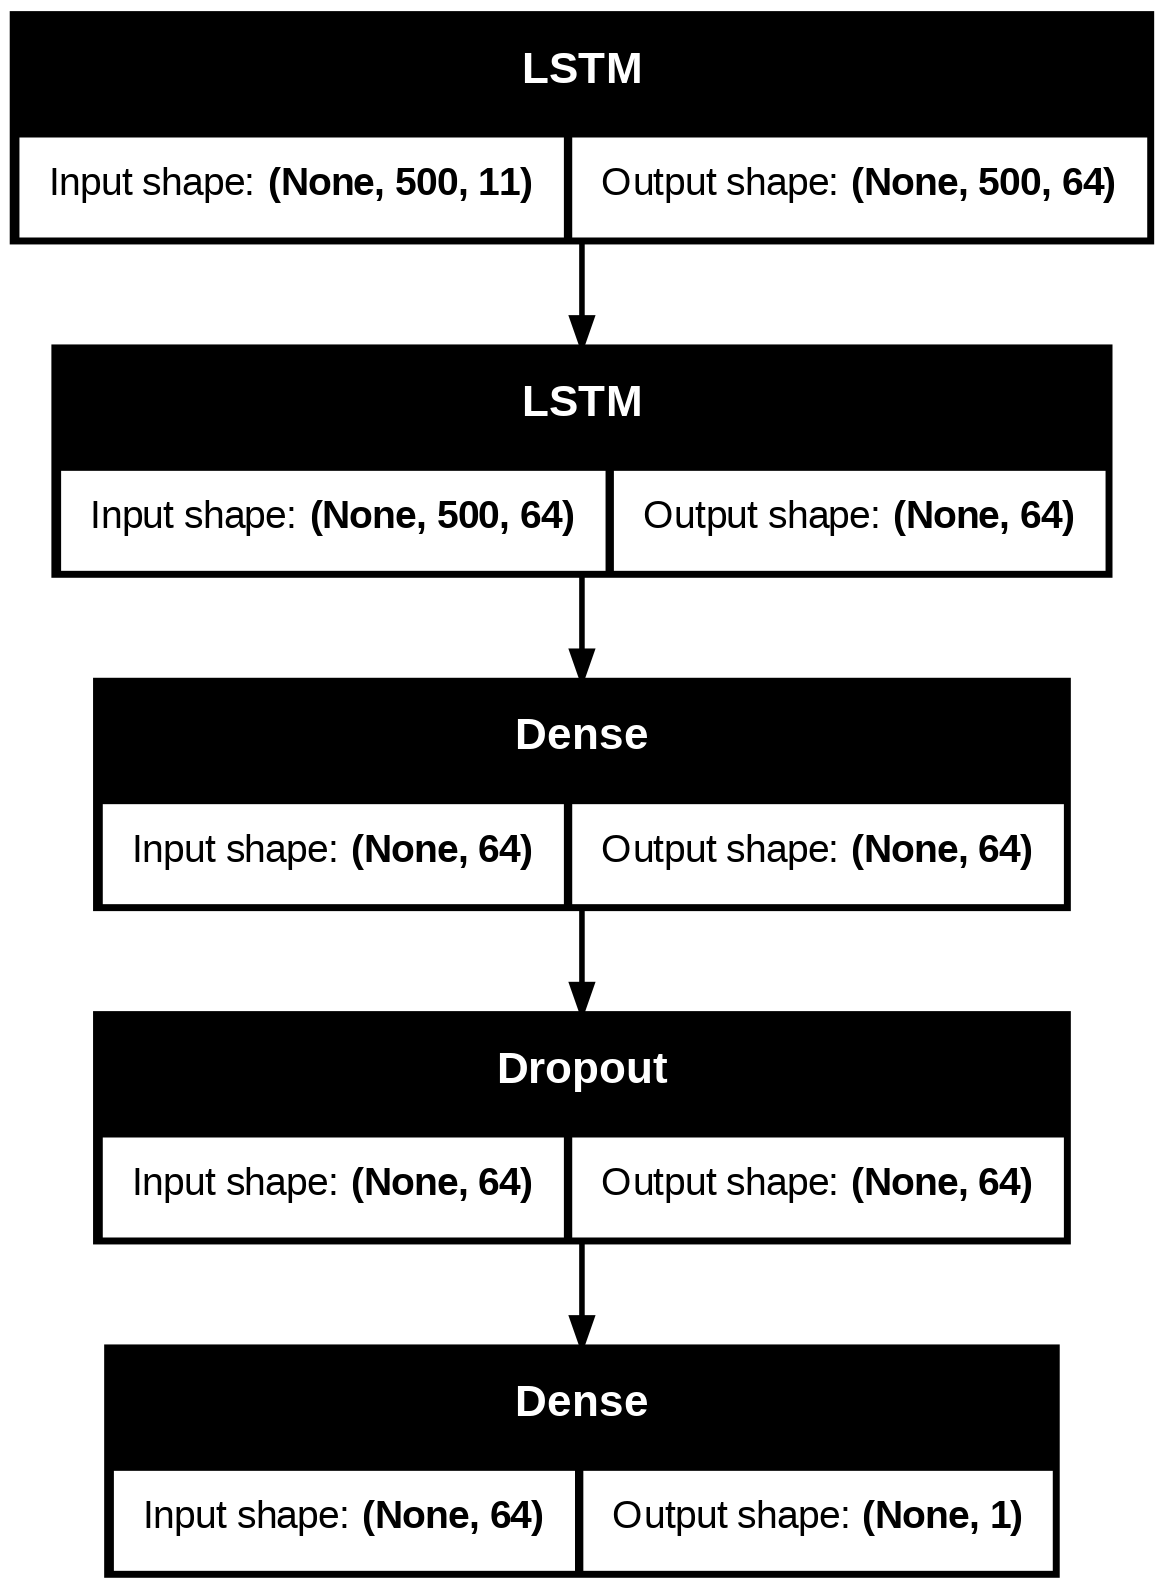

In [ ]:
keras.utils.plot_model(model,show_shapes=True)

# Explanation

It prepares time-series data for each person into the shape expected by an LSTM model:

```python
X.shape → (num_samples, timesteps, num_features)  
y.shape → (num_samples,)
```

---

##  Step-by-Step Breakdown

```python
def prepare_sequences(df):
    grouped = df.groupby("sample_id")
```

###  `df.groupby("sample_id")`

This groups the dataframe by the **person ID** — each person (or sample) has a unique `sample_id`.

Assume your data looks like this:

| sample\_id | frame | feature1 | feature2 | ... | label         |
| ---------- | ----- | -------- | -------- | --- | ------------- |
| 0          | 0     | ...      | ...      |     | autistic      |
| 0          | 1     | ...      | ...      |     | autistic      |
| ...        | ...   | ...      | ...      |     | ...           |
| 1          | 0     | ...      | ...      |     | non\_autistic |

When you call:

```python
grouped = df.groupby("sample_id")
```

It organizes the data like:

```python
grouped = {
    0: DataFrame of 500 rows (frames) for person 0,
    1: DataFrame of 500 rows for person 1,
    ...
}
```

---

###  `for name, group in grouped:`

This loop goes through each group (i.e., each person’s 500-frame time series):

* `name`: the `sample_id` (e.g., 0, 1, 2, ...)
* `group`: the sub-DataFrame with 500 rows for that person

Sample Output:

```plaintext
name -> 0
group ->
   sample_id  frame  feature1  feature2  ...  label
0          0      0     ...       ...         autistic
1          0      1     ...       ...         autistic
...
499        0    499     ...       ...         autistic
```


###  `X.append(group[FEATURES].values)`

Here’s what happens:

* `FEATURES` is a list of your selected 11 features (e.g., knee\_angle, step\_width, etc.)
* `group[FEATURES].values` gives you a `(500, 11)` NumPy array
* You add that array to your list `X`

```python
X.append(group[FEATURES].values)  # shape: (500, 11)
```

---

###  `y.append(group["label"].values[0])`

Since the `label` is repeated in all 500 rows, we just take the **first** one:

```python
y.append(group["label"].values[0])  # 'autistic' or 'non_autistic'
```

So now:

* `X` is a list of shape `(num_samples, 500, 11)`
* `y` is a list of shape `(num_samples,)`

---

###  Final Return

```python
return np.array(X), np.array(y)
```

Let’s say you have 80 people:

```python
X.shape → (80, 500, 11)
y.shape → (80,)
```

Perfect for LSTM input!

---

##  Summary

| Component    | Shape/Type             | Purpose                                       |
| ------------ | ---------------------- | --------------------------------------------- |
| `groupby()`  | groups by person       | Makes it easy to loop over each person’s data |
| `X`          | `(n_samples, 500, 11)` | Time series input for LSTM                    |
| `y`          | `(n_samples,)`         | Class label for each person                   |
| `.values[0]` | scalar label           | All rows have same label, so pick first       |

In [ ]:
X_train[0].shape

(500, 11)

In [ ]:
# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=1e-4),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)
]

# Train model
history = model.fit(
    X_train, y_train_enc,
    validation_split=0.2,
    epochs=30,
    batch_size=8,
    callbacks=callbacks
)


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 8.7314e-05 - val_accuracy: 1.0000 - val_loss: 3.7934e-05 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 1.0891e-04 - val_accuracy: 1.0000 - val_loss: 3.6406e-05 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 2.0778e-04 - val_accuracy: 1.0000 - val_loss: 3.4195e-05 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 1.0000 - loss: 1.1993e-04 - val_accuracy: 1.0000 - val_loss: 3.1852e-05 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.2799e-04 - val_accuracy: 1.0000 - val_loss: 2.9692e-05 - learning_rate: 0.0010
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 1.0000 - loss: 1.1208e-04 - val_accuracy: 1.0000 - val_loss: 2.7739e-05 - learning_rate: 0.0010
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accurac

In [ ]:
# Evaluate on test data
model.evaluate(X_test, y_test_enc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 9.5227e-06


[9.5226869234466e-06, 1.0]

<Axes: title={'center': 'Mdel history'}>

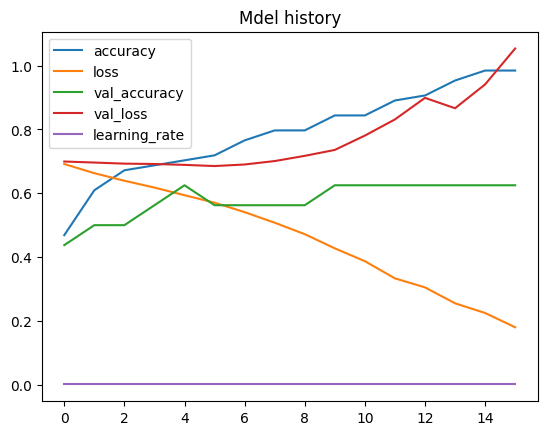

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(title="Mdel history")

# Model 1: considering both univariate and multivariate

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Load dataset
time_series_df = pd.read_excel("train_gait_data.xlsx", sheet_name="time_series")
static_df = pd.read_excel("train_gait_data.xlsx", sheet_name="static")

FEATURES = [f"f{i}" for i in range(11)]

def prepare_sequences(ts_df, static_df):
    grouped = ts_df.groupby("sample_id")
    X_seq, X_static, y = [], [], []

    for sample_id, group in grouped:
        X_seq.append(group[FEATURES].values)
        static_row = static_df[static_df["sample_id"] == sample_id]
        X_static.append(static_row[["cadence", "speed", "steps"]].values[0])
        y.append(static_row["label"].values[0])

    return np.array(X_seq), np.array(X_static), np.array(y)

X_seq, X_static, y = prepare_sequences(time_series_df, static_df)

# Split
X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
    X_seq, X_static, y, test_size=0.2, stratify=y, random_state=42
)

# Model
def create_model(seq_input_shape, static_input_shape):
    seq_input = keras.Input(shape=seq_input_shape, name="sequence_input")
    x = layers.Masking()(seq_input)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation="relu")(x)

    static_input = keras.Input(shape=static_input_shape, name="static_input")
    s = layers.Dense(16, activation="relu")(static_input)

    combined = layers.Concatenate()([x, s])
    z = layers.Dense(32, activation="relu")(combined)
    z = layers.Dropout(0.3)(z)
    output = layers.Dense(1, activation="sigmoid")(z)

    return keras.Model(inputs=[seq_input, static_input], outputs=output)

model = create_model(X_seq.shape[1:], X_static.shape[1:])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1)
]

# Train
history = model.fit(
    {"sequence_input": X_seq_train, "static_input": X_static_train},
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    callbacks=callbacks
)

# Evaluate
model.evaluate(
    {"sequence_input": X_seq_test, "static_input": X_static_test},
    y_test,
    verbose=1
)


# Processing IGAIT data

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load datasets
side_df  = pd.read_csv("side_dataset_time_series.csv")
front_df = pd.read_csv("front_dataset_time_series.csv")

# Encode categorical directions
side_map  = {'left':0, 'right':1, 'stationary':2}
front_map = {'towards':0, 'backwards':1}
side_df['DirCode']  = side_df['Direction'].map(side_map)
front_df['DirCode'] = front_df['Direction'].map(front_map)

# Get sorted list of subjects
subjects = sorted(side_df['subject'].unique())
n = len(subjects)  # 53

# Prepare arrays: side(53,300,9), front(53,249,4)
side_data  = np.zeros((n, 300, 9))
front_data = np.zeros((n, 249, 4))
for i, subj in enumerate(subjects):
    sub_side  = side_df[side_df['subject']==subj].sort_values('frame')
    sub_front = front_df[front_df['subject']==subj].sort_values('frame')
    # Side view: 8 numeric columns + DirCode
    num_cols_side = ['RightHipAngle','LeftHipAngle','RightKneeAngle','LeftKneeAngle',
                     'Right Ankle Angle','Left Ankle Angle','Right Dorsi Plantar Angle','Left Dorsi Plantar Angle']
    side_feat = np.hstack([sub_side[['DirCode']].to_numpy(), sub_side[num_cols_side].to_numpy()])
    # Pad/truncate to 300 frames
    L = side_feat.shape[0]
    if L >= 300:
        side_data[i] = side_feat[:300]
    else:
        side_data[i] = np.vstack([side_feat, np.zeros((300-L, 9))])
    # Front view: 3 numeric columns + DirCode
    num_cols_front = ['R_Adduction_Abduction','L_Adduction_Abduction','Step_Width']
    front_feat = np.hstack([sub_front[['DirCode']].to_numpy(), sub_front[num_cols_front].to_numpy()])
    Lf = front_feat.shape[0]
    if Lf >= 249:
        front_data[i] = front_feat[:249]
    else:
        front_data[i] = np.vstack([front_feat, np.zeros((249-Lf, 4))])

# Create univariate features: e.g. mean step width, mean right hip, mean left hip
uni_features = []
for subj in subjects:
    mean_step = front_df[front_df['subject']==subj]['Step_Width'].mean()
    mean_rhip = side_df[side_df['subject']==subj]['RightHipAngle'].mean()
    mean_lhip = side_df[side_df['subject']==subj]['LeftHipAngle'].mean()
    uni_features.append([mean_step, mean_rhip, mean_lhip])
uni_features = np.array(uni_features)  # shape (53,3)

# Labels per subject (assumed consistent across datasets)
labels = np.array([int(side_df[side_df['subject']==subj]['label'].iloc[0]) for subj in subjects])

# Split into train/test
X_side_train, X_side_test, X_front_train, X_front_test, X_uni_train, X_uni_test, y_train, y_test = train_test_split(
    side_data, front_data, uni_features, labels, test_size=0.2, random_state=42)


# Model Architecture


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Dense, Dropout, BatchNormalization, Activation, concatenate)
from tensorflow.keras.models import Model

# Side-view subnetwork
side_input = Input(shape=(300, 9), name='side_input')
x_side = Conv1D(32, 3, activation=None)(side_input)
x_side = BatchNormalization()(x_side)
x_side = Activation('relu')(x_side)
x_side = MaxPooling1D(2)(x_side)

x_side = Conv1D(64, 3, activation=None)(x_side)
x_side = BatchNormalization()(x_side)
x_side = Activation('relu')(x_side)
x_side = GlobalAveragePooling1D()(x_side)

# Front-view subnetwork
front_input = Input(shape=(249, 4), name='front_input')
x_front = Conv1D(16, 3, activation=None)(front_input)
x_front = BatchNormalization()(x_front)
x_front = Activation('relu')(x_front)
x_front = MaxPooling1D(2)(x_front)

x_front = Conv1D(32, 3, activation=None)(x_front)
x_front = BatchNormalization()(x_front)
x_front = Activation('relu')(x_front)
x_front = GlobalAveragePooling1D()(x_front)

# Univariate-features subnetwork
uni_input = Input(shape=(3,), name='uni_input')
x_uni = Dense(32, activation=None)(uni_input)
x_uni = BatchNormalization()(x_uni)
x_uni = Activation('relu')(x_uni)
x_uni = Dropout(0.5)(x_uni)

x_uni = Dense(16, activation=None)(x_uni)
x_uni = BatchNormalization()(x_uni)
x_uni = Activation('relu')(x_uni)

# Concatenate all features
merged = concatenate([x_side, x_front, x_uni])
z = Dense(64, activation=None)(merged)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Dropout(0.5)(z)

output = Dense(1, activation='sigmoid', name='output')(z)

# Build and compile model
model = Model(inputs=[side_input, front_input, uni_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ side_input          │ (None, 300, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ front_input         │ (None, 249, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 298, 32)   │        896 │ side_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 247, 16)   │        208 │ front_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ uni_input           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 298, 32)   │        128 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 247, 16)   │         64 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │        128 │ uni_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 298, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 247, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 149, 32)   │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 123, 16)   │          0 │ activation_2[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 32)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 147, 64)   │      6,208 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 121, 32)   │      1,568 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32)        │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 64)   │        256 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 121, 32)   │        128 │ conv1d_15[0][0] 

 Total params: 17,857 (69.75 KB)

 Trainable params: 17,345 (67.75 KB)

 Non-trainable params: 512 (2.00 KB)

In [20]:
print("Side NaNs:", np.isnan(X_side_train).sum())
print("Front NaNs:", np.isnan(X_front_train).sum())
print("Uni NaNs:", np.isnan(X_uni_train).sum())

print("Side NaNs:", np.isnan(X_side_test).sum())
print("Front NaNs:", np.isnan(X_front_test).sum())
print("Uni NaNs:", np.isnan(X_uni_test).sum())
print("_____________")
print("Side Infs:", np.isinf(X_side_train).sum())
print("Front Infs:", np.isinf(X_front_train).sum())
print("Uni Infs:", np.isinf(X_uni_train).sum())


print("Side Infs:", np.isinf(X_side_test).sum())
print("Front Infs:", np.isinf(X_front_test).sum())
print("Uni Infs:", np.isinf(X_uni_test).sum())


Side NaNs: 0
Front NaNs: 0
Uni NaNs: 0
Side NaNs: 0
Front NaNs: 0
Uni NaNs: 0
_____________
Side Infs: 0
Front Infs: 0
Uni Infs: 0
Side Infs: 0
Front Infs: 0
Uni Infs: 0


# Training with Callbacks

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    [X_side_train, X_front_train, X_uni_train], y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=8,
    callbacks=callbacks,
    verbose=1
)

# Save the final model
model.save('final_model.h5')


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.6560 - loss: 0.6549

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6368 - loss: 0.6728 - val_accuracy: 0.4000 - val_loss: 1.5542
Epoch 2/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8750 - loss: 0.3916

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7093 - loss: 0.5517 - val_accuracy: 0.4000 - val_loss: 1.2398
Epoch 3/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.2500 - loss: 1.1035

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4847 - loss: 0.8282 - val_accuracy: 0.4000 - val_loss: 1.1652
Epoch 4/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6104

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7485 - loss: 0.6158 - val_accuracy: 0.4000 - val_loss: 0.9889
Epoch 5/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.4656

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6648 - loss: 0.6582 - val_accuracy: 0.4000 - val_loss: 0.8658
Epoch 6/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3750 - loss: 0.9368

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5385 - loss: 0.7015 - val_accuracy: 0.4000 - val_loss: 0.8486
Epoch 7/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7500 - loss: 0.5367

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6673 - loss: 0.6326 - val_accuracy: 0.4000 - val_loss: 0.7731
Epoch 8/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3750 - loss: 0.7865

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5492 - loss: 0.6893 - val_accuracy: 0.6000 - val_loss: 0.6899
Epoch 9/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.4576

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7200 - loss: 0.4548 - val_accuracy: 0.6000 - val_loss: 0.6785
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7450 - loss: 0.5210 - val_accuracy: 0.6000 - val_loss: 0.7032
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7772 - loss: 0.4966 - val_accuracy: 0.6000 - val_loss: 0.7334
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7991 - loss: 0.4716 - val_accuracy: 0.6000 - val_loss: 0.7831
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8241 - loss: 0.4650 - val_accuracy: 0.6000 - val_loss: 0.8395
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8348 - loss: 0.4212 - val_accuracy: 0.6000 - val_loss: 0.8702


# Loading and Making Predictions


In [22]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report

# Load the saved model
loaded_model = load_model('final_model.h5')

# Predict on test set
pred_probs = loaded_model.predict([X_side_test, X_front_test, X_uni_test])
pred_labels = (pred_probs.flatten() > 0.5).astype(int)

# Evaluate
acc = accuracy_score(y_test, pred_labels)
print(f"Test Accuracy: {acc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, pred_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
Test Accuracy: 0.455

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.40      1.00      0.57         4

    accuracy                           0.45        11
   macro avg       0.70      0.57      0.41        11
weighted avg       0.78      0.45      0.37        11



## 1st attempt:
Test Accuracy: 0.636

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       0.00      0.00      0.00         4

    accuracy                           0.64        11
   macro avg       0.32      0.50      0.39        11
weighted avg       0.40      0.64      0.49        11


## 2nd attempt ( filtered NAN data)
Test Accuracy: 0.455

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.40      1.00      0.57         4

    accuracy                           0.45        11
   macro avg       0.70      0.57      0.41        11
weighted avg       0.78      0.45      0.37        11

## 3rd attempt (Using Batch Normalization)
Test Accuracy: 0.455

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.40      1.00      0.57         4

    accuracy                           0.45        11
   macro avg       0.70      0.57      0.41        11
weighted avg       0.78      0.45      0.37        11


<Axes: title={'center': 'Attempt 3- Batch Normalization'}>

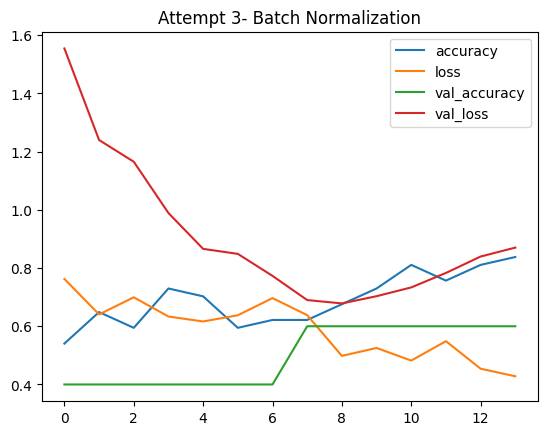

In [23]:
pd.DataFrame(history.history).plot(title="Attempt 3- Batch Normalization")